<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline, </h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [56]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib qt')   
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.base.rois import register_ROIs
from caiman.base.traces import trace
import os
import cv2
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import matplotlib.pyplot as plt


try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')
import bokeh.plotting as bpl
bpl.output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [2]:
import caiman as cm
import numpy as np
from caiman.source_extraction import cnmf
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.base.rois import register_ROIs
import pickle

In [3]:
root = '/home/sebastian/Desktop/cnmfs/32364'
roots = []
paths = {}
frames_paths = {}
rests = {}

for i in os.listdir(root):
    if int(i[-2:])<15:
        root_name = (os.path.join(root,i))
        roots.append(root_name)
        for f in os.listdir(os.path.join(root,i)):
            if 'cnmf.pkl' in f: 
                paths[root_name]=(os.path.join(root,i,f))
            if 'frames.npy' in f:
                frames_paths[root_name]=(os.path.join(root,i,f))

roots.sort()
print(roots)

['/home/sebastian/Desktop/cnmfs/32364/20170710', '/home/sebastian/Desktop/cnmfs/32364/20170711', '/home/sebastian/Desktop/cnmfs/32364/20170712', '/home/sebastian/Desktop/cnmfs/32364/20170713', '/home/sebastian/Desktop/cnmfs/32364/20170714']


### (Re)start cluster.  

In [4]:
frate = 10 # movie frame rate
gSig = 3   # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 10  # average diameter of a neuron

min_corr = .3 # min correlation of peak (from correlation image)
min_pnr = 5 # min peak to noise ratio
min_SNR = 3 # adaptive way to set threshold on the transient size


In [5]:
try:
    dview.terminate() # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=10,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

In [6]:
cnmfs = {}
n_s = [0]

for r in roots:
    cnmfs[r] = cnmf.CNMF(n_processes=n_processes) 
    cnmfs[r].load(paths[r])
    n_s.append(cnmfs[r].C.shape[0])


In [7]:
from caiman.utils.stats import calc_x_rest

frames = {}
frame_pts = {}
for r in roots:
    frame_pt = np.load(frames_paths[r])
    frame_pts[r]=frame_pt
    frames[r] = calc_x_rest(frame_pt,cnmfs[r].C.shape[1])


In [8]:
def check_stable(linsig): return (((linsig>-linsig.std())*(linsig<linsig.std())).sum()/np.product(linsig.shape))
def check_increase(linsig): return (((linsig>linsig.std())).sum()/np.product(linsig.shape))
def check_decrease(linsig): return (((linsig<-linsig.std())).sum()/np.product(linsig.shape)) 

In [9]:
# from caiman.utils.stats import norm_corr_mat
# from caiman.utils.stats import yuste_bootstrap


# norm_mats = {}
# aps = {}
# actives = {}
# passives = {}
# corrs = {}
# trends = {}
# boots = {}
# sigs = {}
# sigmats = {}
# W = {}
# B = {}

# for i,r in enumerate(roots):
#     spikes = cnmfs[r].S
#     aps[r]=[]
    
#     n=0
#     for i,p in enumerate(frame_pts[r]):
#         aps[r].append(spikes[:,n:n+p])
#         n+=p

#     actives[r] = aps[r][::2]
#     passives[r] = aps[r][1::2]

#     corrs[r]=[]
#     for a in actives[r]:
#         corrs[r].append(norm_corr_mat(a))
        
        
        

#     boots[r] = []

#     for i,a in enumerate(actives[r]):
#         boots[r].append(yuste_bootstrap(a,1000))

#     sigs[r]=[]
    

#     for i,c in enumerate(corrs[r]):
#         sigs[r].append(c>(boots[r][i].mean(0)+boots[r][i].std(0)*3))

        
        
#     sigmats[r] =  np.concatenate([sigs[r]]).astype(np.float)    
#     W[r] = np.zeros(sigs[r][0].shape)
#     B[r] = np.zeros(sigs[r][0].shape)
    
#     for i in range(sigmats[r].shape[1]):
#         for j in range(sigmats[r].shape[2]):
#             x = sigmats[r][:,i,j]
#             y= np.arange(sigmats[r].shape[0])
#             W[r][i,j],B[r][i,j] = np.polyfit(y, x,1)
        
#     trends[r]=[check_stable(W[r]),check_increase(W[r]),check_decrease(W[r])]
    
    
        

In [10]:
# plt.figure(figsize=(20,10))

# n=1

# for i,r in enumerate(roots[:-1]):
#     plt.subplot(2,4,i+1)
#     plt.title('day '+str(i+1))
#     plt.imshow(W[r],cmap='inferno')
#     plt.subplot(2,4,i+5)
#     plt.bar([0,1,2],trends[r],tick_label=['stable','decrease','increase'],)
#     plt.ylim([0,1])
    

In [11]:

        
# plt.figure(figsize=(15,10))

# for i,b in enumerate(boots[r]):
#     plt.subplot(2,3,i+1)
#     plt.imshow(b.mean(0),vmin=0, vmax=0.2,cmap='inferno')


In [ ]:
# plt.figure(figsize=(15,15))

# n=1

# for i,r in enumerate(roots):
#     for j,p in enumerate(sigmats[r]):
#         plt.subplot(5,5,n)
#         n+=1
#         plt.imshow(p,aspect='auto')

In [55]:
from caiman.utils.stats import norm_corr_mat
from caiman.utils.stats import yuste_bootstrap

week_norm_mats = {}
week_aps = {}
week_actives = {}
week_passives = {}
week_corrs = {}
week_trends = {}
week_boots = {}
week_sigs = {}
week_sigmats = {}
week_W = {}
week_B = {}


for i,r in enumerate(roots):

    spikes = cnmfs[r].S
    week_aps[r]=[]
    
    n=0
    for i,p in enumerate(frame_pts[r]):
        week_aps[r].append(spikes[:,n:n+p])
        n+=p

    
    
    week_actives[r] = np.concatenate(week_aps[r][::2],1)
    week_passives[r] = np.concatenate(week_aps[r][1::2],1)

    week_corrs[r]=[]
    for a in [week_actives[r]]:
        week_corrs[r].append(norm_corr_mat(a))
        
        
        

    week_boots[r] = []

    for i,a in enumerate([week_actives[r]]):
        print(r)
        week_boots[r].append(yuste_bootstrap(a,10000))

    week_sigs[r]=[]
    

    for i,c in enumerate(week_corrs[r]):
        week_sigs[r].append(c>(week_boots[r][i].mean(0)+week_boots[r][i].std(0)*3))

        
        
    week_sigmats[r] =  np.concatenate([week_sigs[r]]).astype(np.float)  
    
    
#     week_W[r] = np.zeros(week_sigs[r][0].shape)
#     week_B[r] = np.zeros(week_sigs[r][0].shape)
    
#     for i in range(week_sigmats[r].shape[1]):
#         for j in range(week_sigmats[r].shape[2]):
#             x = week_sigmats[r][:,i,j]
#             y= np.arange(week_sigmats[r].shape[0])
#             week_W[r][i,j],week_B[r][i,j] = np.polyfit(y, x,1)
        
#     week_trends[r]=[check_stable(week_W[r]),check_increase(week_W[r]),check_decrease(week_W[r])]



/home/sebastian/Desktop/cnmfs/32364/20170710


/home/sebastian/Documents/CaImAn/caiman/utils/stats.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return(np.inner(spike_train_1,spike_train_2)/((np.linalg.norm(spike_train_1)+np.linalg.norm(spike_train_2))/2))


/home/sebastian/Desktop/cnmfs/32364/20170711


/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater


/home/sebastian/Desktop/cnmfs/32364/20170712
/home/sebastian/Desktop/cnmfs/32364/20170713
/home/sebastian/Desktop/cnmfs/32364/20170714


In [85]:

for i,r in enumerate(roots):
    np.save(os.path.join(root,'_'.join(['32364',r.split('/')[-1],'boots.npy'])),week_boots[r])
    
#plt.plot(time2)

In [86]:
plt.figure(figsize=(15,12))

for i ,r in enumerate(roots):
    plt.subplot(4,5,i+1)
    plt.imshow(week_boots[r][0].mean(0)) 
    plt.title('baseline')
    plt.subplot(4,5,i+6)
    plt.imshow(week_corrs[r][0])
    plt.title('correlation')
    plt.subplot(4,5,i+11)
    plt.title('significant correlations')
    plt.imshow(week_sigmats[r].sum(0))

### Combine cells over days:


In [20]:
matches = {}
for i,r1 in enumerate(roots[:-1]):
    matches[r1] = {}
    for j,r2 in enumerate(roots[i+1:]):
        cnm1 = cnmfs[r1]
        cnm2 = cnmfs[r2]
        matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance = register_ROIs(cnm1.A,cnm2.A,cnm1.dims,cnm1.cn_filter,cnm2.cn_filter)
        
        matches[r1][r2]=[matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance].copy()


New Pair **
FOV: 0, shape: 225,95 total cost: 54.465926
0.03847074508666992
{'recall': 0.32, 'precision': 0.7578947368421053, 'accuracy': 0.2903225806451613, 'f1_score': 0.45}
New Pair **
FOV: 0, shape: 225,195 total cost: 138.711686
0.30057430267333984
{'recall': 0.4622222222222222, 'precision': 0.5333333333333333, 'accuracy': 0.3291139240506329, 'f1_score': 0.49523809523809526}
New Pair **
FOV: 0, shape: 225,128 total cost: 77.443863
0.11832284927368164
{'recall': 0.38222222222222224, 'precision': 0.671875, 'accuracy': 0.32209737827715357, 'f1_score': 0.48725212464589235}
New Pair **
FOV: 0, shape: 225,106 total cost: 67.866583
0.06206512451171875
{'recall': 0.29333333333333333, 'precision': 0.6226415094339622, 'accuracy': 0.2490566037735849, 'f1_score': 0.3987915407854985}
New Pair **
FOV: 0, shape: 95,195 total cost: 66.344428
0.04787397384643555
{'recall': 0.5684210526315789, 'precision': 0.27692307692307694, 'accuracy': 0.2288135593220339, 'f1_score': 0.3724137931034483}
New Pair

In [21]:
match_sigs = {}
for i,r1 in enumerate(roots[:-1]):
    match_sigs[r1] = {}
    for j,r2 in enumerate(roots[i+1:]):
        matched_ROIs1  = matches[r1][r2][0]
        matched_ROIs2  = matches[r1][r2][1]
        
        match_sigs[r1][r2]=[week_sigmats[r1][0,matched_ROIs1][:,matched_ROIs1],week_sigmats[r2][0,matched_ROIs2][:,matched_ROIs2]]


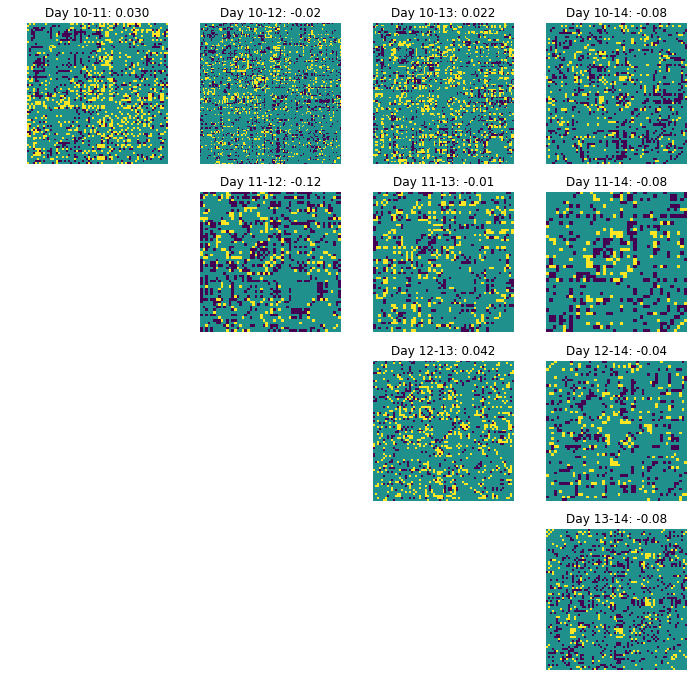

In [31]:
plt.figure(figsize=(15,15))

for i,r1 in enumerate(roots[:-1]):
    for j,r2 in enumerate(roots[i+1:]): 
        img = match_sigs[r1][r2][1]-match_sigs[r1][r2][0]
        plt.subplot(5,5,i*5+j+1+(i%5))
        plt.title(' '.join(['Day',str(r1).split('/')[-1][-2:]+'-'+str(r2).split('/')[-1][-2:]+':',str(img.mean())[0:5]]))
        
        plt.imshow(img)
        plt.axis('off')
        #plt.text(-5,-5,'Trend: '+ str(img.mean()))

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


Text(0,0.5,'% significant correlations')

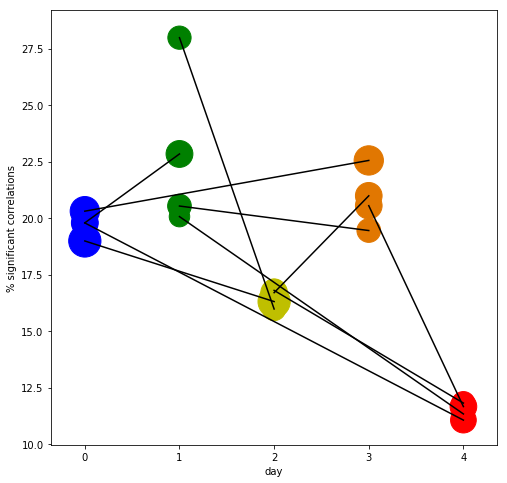

In [54]:
plt.figure(figsize=(8,8))

plt.hold(True)

colors=['b','g','y', 'xkcd:pumpkin','r']

for i,r1 in enumerate(roots[:-1]):
    for j,r2 in enumerate(roots[i+1:]): 
        m1 = match_sigs[r1][r2][1]
        m0 = match_sigs[r1][r2][0]
        plt.scatter([i,j+i+1],[m0.mean()*100,m1.mean()*100],[m0.shape[0]*10,m1.shape[0]*10],c=[colors[i],colors[i+j+1]],)
        plt.plot([i,j+i+1],[m0.mean()*100,m1.mean()*100],color='k')
        plt.xticks(range(5))
plt.xlabel('day')
plt.ylabel('% significant correlations')

In [ ]:
match_mat = np.zeros([sum(n_s),sum(n_s)])

n_s_int = np.cumsum(n_s)

for i,k1 in enumerate(matches.keys()):
    for j,k2 in enumerate(matches[k1].keys()):
        n1 = n_s_int[i]
        n2 = n_s_int[i+j]
        #print(k1,k2,i,j+i)
        ROI1 = np.array(matches[k1][k2][0])+n1
        ROI2 = np.array(matches[k1][k2][1])+n2
        #ROI2 = np.array(matches[k1][k2][0])+n2
        match_mat[ROI1,ROI2]+=1
        match_mat[ROI2,ROI1]+=1

for n1 in n_s_int[:-1]:
    match_mat[:,n1]+=1
    match_mat[n1,:]+=1
        
        
        
plt.imshow(match_mat)

In [ ]:

    
plt.figure(1,figsize=(40, 40))
    
for i,r in enumerate(roots[:-1]):
    plt.subplot(4,2,2*i+1)
    cnm1 = cnmfs[r]
    cnm2 = cnmfs[roots[i+1]]
    crd3 = cm.utils.visualization.plot_contours(cnm1.A[:,matches[r][0]], cnm1.cn_filter, thr=.9, vmax=0.95)
    plt.subplot(4,2,2*i+2)
    crd4 = cm.utils.visualization.plot_contours(cnm2.A[:,matches[r][1]], cnm2.cn_filter, thr=.9, vmax=0.95)
    

    
    

In [35]:
cnmfs

{'/home/sebastian/Desktop/cnmfs/32364/20170710': <caiman.source_extraction.cnmf.cnmf.CNMF at 0x7f63c01ad390>,
 '/home/sebastian/Desktop/cnmfs/32364/20170711': <caiman.source_extraction.cnmf.cnmf.CNMF at 0x7f63c0112240>,
 '/home/sebastian/Desktop/cnmfs/32364/20170712': <caiman.source_extraction.cnmf.cnmf.CNMF at 0x7f63c0bcb8d0>,
 '/home/sebastian/Desktop/cnmfs/32364/20170713': <caiman.source_extraction.cnmf.cnmf.CNMF at 0x7f63c02c8f60>,
 '/home/sebastian/Desktop/cnmfs/32364/20170714': <caiman.source_extraction.cnmf.cnmf.CNMF at 0x7f63c0117c18>}

In [26]:
import matplotlib.pyplot as plt
plt.figure(2,figsize=(20, 15))

plt.subplot(1,2,1)
crd3 = cm.utils.visualization.plot_contours(cnm1.A[:,matched_ROIs1], cnm1.cn_filter, thr=.9, vmax=0.95)
plt.subplot(1,2,2)
crd4 = cm.utils.visualization.plot_contours(cnm2.A[:,matched_ROIs2], cnm2.cn_filter, thr=.9, vmax=0.95)

NameError: name 'matched_ROIs1' is not defined

In [27]:
%matplotlib qt

spikes1 = cnm1.S[matched_ROIs1[::2],:]
spikes2 = cnm2.S[matched_ROIs2[::2],:]

trc1 = trace(spikes1.T)
trc2 = trace(spikes2.T)

plt.figure(3,figsize=(20, 20))


plt.subplot(1,2,1)
plt.title('spikes day 1:')
trc1.plot(cmap = plt.cm.tab20b)


plt.subplot(1,2,2)
plt.title('spikes day 2:')
trc2.plot(cmap = plt.cm.tab20b)


NameError: name 'matched_ROIs1' is not defined

In [ ]:
cnm1.S[0].shape

### Stop cluster

In [ ]:
#%%
cm.stop_server(dview=dview)

In [ ]:
##TODO:

# from caiman import minisom

# # Initialization and training
# som = minisom.MiniSom(420, 600, cnm1.S.shape[1], sigma=10.0, learning_rate=0.5)
# som.random_weights_init(cnm1.S)
# print("Training...")
# som.train_random(cnm1.S, 10)  # random training
# print("\n...ready!")